# Modeling Hot Water Energy

### Attach current folder to project directory
### Ensure Seed for reproducability
### Set GPU configurations

In [1]:
seed_value = 123

import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Select the period at which we perform experiments

In [3]:
period = 6  # the period to sample the data at. 1 period= 5 minutes

### Read the cleaned data

In [4]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


Finished 'dataframeplot' in 0.0336 secs


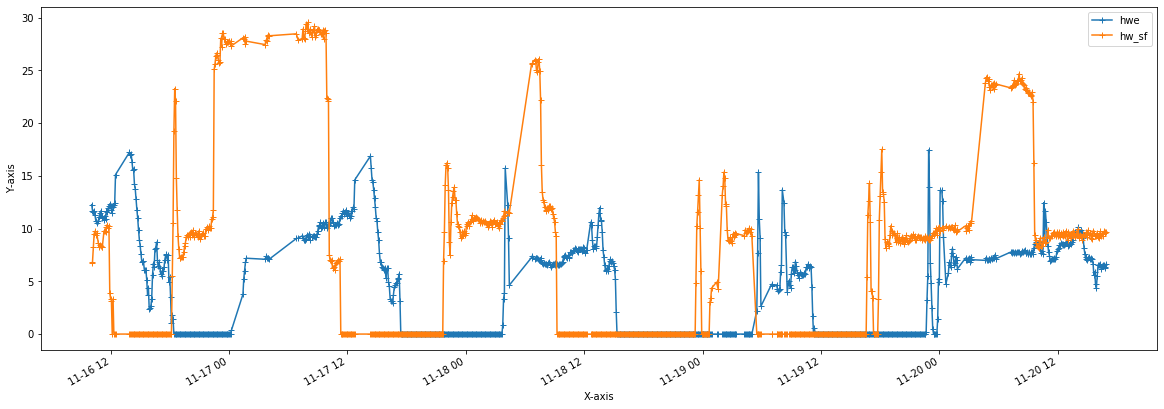

In [13]:
#%matplotlib notebook
dp.dataframeplot(df=df.loc[df.index[:1000], ['hwe','hw_sf']],
                lazy=True,
                legend=True,
                style='+-')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

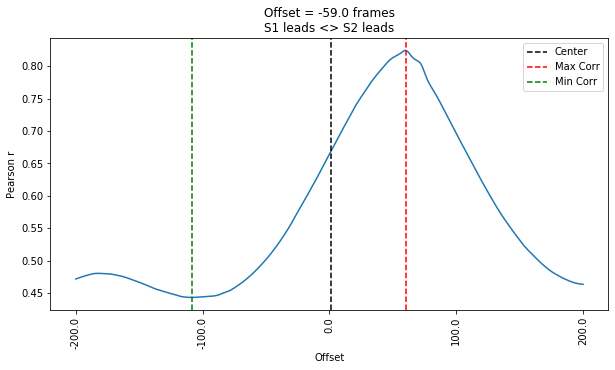

In [11]:
d1 = df['hwe']
d2 = df['hw_sf']
seconds = 200
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((seconds+1)*fps), seconds/2))
ax.set_xticklabels(np.arange(-int(seconds*fps),int((seconds+1)*fps),seconds/2), rotation=90);
plt.legend()

# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

### Since this implies that Hot water flow leads the Hot Water Energy by approximately 60 frames or approximately 5 hours. We will use the flow as an indicator of the hybrid mode changes in the energy prediction problem. 

### Next steps:
1. Shift the hot water energy upwards/move back in time by 59 units.
2. Shift the energy by one more unit for the final prediction. 
3. For training: We break the data into batches separated by 0 energy determined by hot water flow
4. For testing:

    a. Either we do online testing where we utilize the current flow information to decide to predict or not.
    
    b. Again create batches of data based on the flow information and predict only in those batches.

### Sum half hour energy data

In [69]:
# return a new column which is the sum of previous window_size values
def windowsum(df, window_size: int, column_name: str):
    return df[[column_name]].rolling(window=window_size, min_periods=window_size).sum()

df['30min_hwe'] = windowsum(df,window_size=period, column_name='hwe')
df = dp.dropNaNrows(df)

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.090181,72.197220,85.0,10.762690,1.567676,555.0,72.438095,0.002307,9.412869,114.48685,93.302300,69.271747
2018-11-16 10:35:00,31.090181,72.197220,85.0,10.564563,19.244667,561.0,72.438095,0.002314,9.568605,117.11233,96.343720,67.570122
2018-11-16 10:45:00,31.090181,72.197220,85.0,10.697302,23.290321,573.0,72.400000,0.006438,8.650812,113.07264,94.614395,66.565878
2018-11-16 10:50:00,31.090181,71.896065,85.0,11.076882,16.465296,579.0,72.400000,0.007606,8.232664,114.02831,95.410160,66.064175
2018-11-16 10:55:00,31.090181,71.596306,89.0,11.479505,5.206500,589.0,72.438095,0.010025,8.469596,115.26057,96.472720,65.850071


### Smooth the data 

In [6]:
# Smoothing the data
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

df_smoothed = dp.dfsmoothing(df=df,
                             column_names=list(df.columns),
                             order=order,
                             Wn=cutoff,
                             T=T)

### Sample data at half hour

In [7]:
# Sample the data at half hour intervals
df_smoothed = dp.sample_timeseries_df(df_smoothed, period=period)
df_smoothed.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,30.993272,72.150486,84.717147,10.259725,1.567559,560.337060,72.428025,-0.019260,9.423610,114.563037,92.970058,67.252497
2018-11-16 11:00:00,30.889967,71.491976,86.906144,10.717770,1.628633,595.256072,72.429389,-0.077976,8.985507,112.734029,92.385405,65.518758
2018-11-16 11:30:00,31.029884,71.140593,88.827702,11.719749,1.369406,610.780989,72.443166,-0.092517,7.725145,110.744792,91.701689,67.373714
2018-11-16 12:00:00,32.014107,71.464986,90.182589,13.376567,0.665984,583.547763,72.468773,0.017836,4.889709,108.046403,91.075094,75.193039
2018-11-16 12:30:00,34.152125,72.431938,89.892601,14.394451,-0.000064,505.321631,72.478809,0.216811,1.718718,105.323471,91.328901,83.948465


### Create 7 day chunks of data

In [8]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df_smoothed[['oat', 'orh', 'sat', 'ghi', 'hw_sf', '30min_hwe', 'hw_st']],
                      subsequence=True,
                      period=period,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 61


### Custom way to create Training Data; Choose inputs, outputs, lags, train-test splits etc

In [45]:
data_weeks = 52 # Create a large initial block 6 months ~ 26 weeks of training and testing data
splitvalue =  (data_weeks-1)/data_weeks  # One week for training
weeklist = []  # create list of training, testing arrays
inputcols = ['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st']  # input data
outputcols = ['30min_hwe']  # output data
lag = -1  # predict next time step energy

from pandas import concat
def quickmerge(listdf):
    return concat(listdf)

### Initial Data Block for offline training

In [46]:
datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)

X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue
    )
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler
    })

### Create small blocks of data for weekly training

In [47]:
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue
    )
    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 10


### Print size and shape of data to feed to the LSTM for sanity checks

In [ ]:
for week in weeklist:
    for key,value in week.items():
        if key != 'y_scaler':
            print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

### Create Folder to save models and tensorboard logs

In [52]:
path = '../results/lstm_hwe_trial2/'
!rm -rf ../results/lstm_hwe_trial2

# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Clear the Tensorflow graph from previous training

In [53]:
try:
    del model
except NameError:
    pass

K.clear_session()

### Configure the LSTM model architecture

In [54]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':5000,
    'retrain_from_layers':2
}

### Start the week by week training procedure

In [55]:
modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']
    y_scaler = weekdata['y_scaler']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        nn_model = mp.lstm_model_transferlearning(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=period)

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                           densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])
        
        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        nn_model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train, y_train, X_test, y_test, epochs=modelconfig['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Idx=weekdata['Id'],
                                                     outputdim_names=['Hot Water Energy'])
    
    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False
            
    if reinitialize:  
        for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())
    
    # compile model
    nn_model.model_compile()

  0%|          | 0/10 [00:00<?, ?it/s]

Train on 14995 samples, validate on 295 samples
Epoch 1/5000
 - 5s - loss: 0.0337 - val_loss: 0.1436
Epoch 2/5000
 - 3s - loss: 0.0298 - val_loss: 0.1381
Epoch 3/5000
 - 3s - loss: 0.0276 - val_loss: 0.1261
Epoch 4/5000
 - 3s - loss: 0.0221 - val_loss: 0.0783
Epoch 5/5000
 - 3s - loss: 0.0169 - val_loss: 0.0572
Epoch 6/5000
 - 3s - loss: 0.0159 - val_loss: 0.0493
Epoch 7/5000
 - 3s - loss: 0.0153 - val_loss: 0.0444
Epoch 8/5000
 - 3s - loss: 0.0150 - val_loss: 0.0412
Epoch 9/5000
 - 3s - loss: 0.0147 - val_loss: 0.0390
Epoch 10/5000
 - 3s - loss: 0.0146 - val_loss: 0.0372
Epoch 11/5000
 - 3s - loss: 0.0144 - val_loss: 0.0357
Epoch 12/5000
 - 3s - loss: 0.0143 - val_loss: 0.0343
Epoch 13/5000
 - 3s - loss: 0.0141 - val_loss: 0.0332
Epoch 14/5000
 - 3s - loss: 0.0140 - val_loss: 0.0323
Epoch 15/5000
 - 3s - loss: 0.0139 - val_loss: 0.0315
Epoch 16/5000
 - 3s - loss: 0.0138 - val_loss: 0.0307
Epoch 17/5000
 - 3s - loss: 0.0137 - val_loss: 0.0300
Epoch 18/5000
 - 3s - loss: 0.0136 - val_lo

 10%|█         | 1/10 [03:08<28:20, 188.93s/it]

Train on 14796 samples, validate on 291 samples
Epoch 56/5000
 - 2s - loss: 0.0343 - val_loss: 0.0266
Epoch 57/5000
 - 1s - loss: 0.0110 - val_loss: 0.0185
Epoch 58/5000
 - 1s - loss: 0.0109 - val_loss: 0.0187
Epoch 59/5000
 - 1s - loss: 0.0110 - val_loss: 0.0188
Epoch 60/5000
 - 1s - loss: 0.0106 - val_loss: 0.0184
Epoch 61/5000
 - 1s - loss: 0.0106 - val_loss: 0.0186
Epoch 62/5000
 - 1s - loss: 0.0106 - val_loss: 0.0188
Epoch 63/5000
 - 1s - loss: 0.0106 - val_loss: 0.0188
Epoch 64/5000
 - 1s - loss: 0.0105 - val_loss: 0.0188
Epoch 65/5000
 - 1s - loss: 0.0105 - val_loss: 0.0188
Epoch 66/5000
 - 1s - loss: 0.0105 - val_loss: 0.0188
Epoch 67/5000
 - 1s - loss: 0.0105 - val_loss: 0.0188
Epoch 68/5000
 - 1s - loss: 0.0105 - val_loss: 0.0188


 20%|██        | 2/10 [03:26<18:21, 137.63s/it]

Train on 14564 samples, validate on 286 samples
Epoch 69/5000
 - 2s - loss: 0.0287 - val_loss: 0.0225
Epoch 70/5000
 - 1s - loss: 0.0108 - val_loss: 0.0202
Epoch 71/5000
 - 2s - loss: 0.0109 - val_loss: 0.0205
Epoch 72/5000
 - 2s - loss: 0.0109 - val_loss: 0.0206
Epoch 73/5000
 - 1s - loss: 0.0106 - val_loss: 0.0199
Epoch 74/5000
 - 2s - loss: 0.0105 - val_loss: 0.0201
Epoch 75/5000
 - 2s - loss: 0.0105 - val_loss: 0.0202
Epoch 76/5000
 - 2s - loss: 0.0105 - val_loss: 0.0202
Epoch 77/5000
 - 2s - loss: 0.0104 - val_loss: 0.0202
Epoch 78/5000
 - 2s - loss: 0.0104 - val_loss: 0.0202
Epoch 79/5000
 - 2s - loss: 0.0104 - val_loss: 0.0202
Epoch 80/5000
 - 1s - loss: 0.0104 - val_loss: 0.0203
Epoch 81/5000
 - 2s - loss: 0.0104 - val_loss: 0.0203


 30%|███       | 3/10 [03:48<12:00, 102.95s/it]

Train on 14605 samples, validate on 287 samples
Epoch 82/5000
 - 2s - loss: 0.0559 - val_loss: 0.0046
Epoch 83/5000
 - 1s - loss: 0.0116 - val_loss: 0.0020
Epoch 84/5000
 - 2s - loss: 0.0110 - val_loss: 0.0020
Epoch 85/5000
 - 2s - loss: 0.0111 - val_loss: 0.0020
Epoch 86/5000
 - 1s - loss: 0.0109 - val_loss: 0.0045
Epoch 87/5000
 - 2s - loss: 0.0108 - val_loss: 0.0045
Epoch 88/5000
 - 2s - loss: 0.0108 - val_loss: 0.0045
Epoch 89/5000
 - 2s - loss: 0.0107 - val_loss: 0.0045
Epoch 90/5000
 - 2s - loss: 0.0107 - val_loss: 0.0044
Epoch 91/5000
 - 2s - loss: 0.0107 - val_loss: 0.0044
Epoch 92/5000
 - 2s - loss: 0.0107 - val_loss: 0.0044
Epoch 93/5000
 - 2s - loss: 0.0107 - val_loss: 0.0043


 40%|████      | 4/10 [04:10<07:50, 78.42s/it] 

Train on 14680 samples, validate on 288 samples
Epoch 94/5000
 - 2s - loss: 0.0425 - val_loss: 0.0030
Epoch 95/5000
 - 1s - loss: 0.0107 - val_loss: 0.0029
Epoch 96/5000
 - 1s - loss: 0.0108 - val_loss: 0.0029
Epoch 97/5000
 - 1s - loss: 0.0109 - val_loss: 0.0029
Epoch 98/5000
 - 2s - loss: 0.0107 - val_loss: 0.0052
Epoch 99/5000
 - 2s - loss: 0.0106 - val_loss: 0.0050
Epoch 100/5000
 - 2s - loss: 0.0106 - val_loss: 0.0048
Epoch 101/5000
 - 2s - loss: 0.0106 - val_loss: 0.0047
Epoch 102/5000
 - 2s - loss: 0.0105 - val_loss: 0.0048
Epoch 103/5000
 - 2s - loss: 0.0105 - val_loss: 0.0048


 50%|█████     | 5/10 [04:27<04:59, 59.99s/it]

Train on 14644 samples, validate on 288 samples
Epoch 104/5000
 - 2s - loss: 0.0452 - val_loss: 0.0062
Epoch 105/5000
 - 2s - loss: 0.0105 - val_loss: 0.0072
Epoch 106/5000
 - 2s - loss: 0.0106 - val_loss: 0.0073
Epoch 107/5000
 - 2s - loss: 0.0106 - val_loss: 0.0120
Epoch 108/5000
 - 2s - loss: 0.0104 - val_loss: 0.0115
Epoch 109/5000
 - 2s - loss: 0.0104 - val_loss: 0.0113
Epoch 110/5000
 - 2s - loss: 0.0104 - val_loss: 0.0111
Epoch 111/5000
 - 2s - loss: 0.0103 - val_loss: 0.0113
Epoch 112/5000
 - 2s - loss: 0.0103 - val_loss: 0.0114


 60%|██████    | 6/10 [04:43<03:08, 47.00s/it]

Train on 14651 samples, validate on 288 samples
Epoch 113/5000
 - 2s - loss: 0.0227 - val_loss: 0.0039
Epoch 114/5000
 - 2s - loss: 0.0105 - val_loss: 0.0043
Epoch 115/5000
 - 2s - loss: 0.0106 - val_loss: 0.0043
Epoch 116/5000
 - 2s - loss: 0.0108 - val_loss: 0.0050
Epoch 117/5000
 - 2s - loss: 0.0105 - val_loss: 0.0050
Epoch 118/5000
 - 2s - loss: 0.0105 - val_loss: 0.0050
Epoch 119/5000
 - 2s - loss: 0.0104 - val_loss: 0.0049
Epoch 120/5000
 - 2s - loss: 0.0104 - val_loss: 0.0051
Epoch 121/5000
 - 2s - loss: 0.0104 - val_loss: 0.0052


 70%|███████   | 7/10 [05:00<01:53, 37.90s/it]

Train on 14480 samples, validate on 284 samples
Epoch 122/5000
 - 2s - loss: 0.0248 - val_loss: 0.0104
Epoch 123/5000
 - 2s - loss: 0.0104 - val_loss: 0.0102
Epoch 124/5000
 - 2s - loss: 0.0105 - val_loss: 0.0104
Epoch 125/5000
 - 1s - loss: 0.0106 - val_loss: 0.0105
Epoch 126/5000
 - 2s - loss: 0.0108 - val_loss: 0.0091
Epoch 127/5000
 - 2s - loss: 0.0104 - val_loss: 0.0095
Epoch 128/5000
 - 2s - loss: 0.0103 - val_loss: 0.0097
Epoch 129/5000
 - 2s - loss: 0.0103 - val_loss: 0.0098
Epoch 130/5000
 - 2s - loss: 0.0103 - val_loss: 0.0099
Epoch 131/5000
 - 2s - loss: 0.0103 - val_loss: 0.0099
Epoch 132/5000
 - 2s - loss: 0.0103 - val_loss: 0.0100
Epoch 133/5000
 - 2s - loss: 0.0103 - val_loss: 0.0101
Epoch 134/5000
 - 1s - loss: 0.0102 - val_loss: 0.0101


 80%|████████  | 8/10 [05:23<01:06, 33.40s/it]

Train on 14499 samples, validate on 285 samples
Epoch 135/5000
 - 2s - loss: 0.0407 - val_loss: 0.0113
Epoch 136/5000
 - 1s - loss: 0.0101 - val_loss: 0.0097
Epoch 137/5000
 - 2s - loss: 0.0103 - val_loss: 0.0097
Epoch 138/5000
 - 2s - loss: 0.0104 - val_loss: 0.0098
Epoch 139/5000
 - 2s - loss: 0.0107 - val_loss: 0.0078
Epoch 140/5000
 - 2s - loss: 0.0103 - val_loss: 0.0080
Epoch 141/5000
 - 2s - loss: 0.0103 - val_loss: 0.0082
Epoch 142/5000
 - 2s - loss: 0.0103 - val_loss: 0.0083
Epoch 143/5000
 - 2s - loss: 0.0102 - val_loss: 0.0082
Epoch 144/5000
 - 2s - loss: 0.0102 - val_loss: 0.0082
Epoch 145/5000
 - 2s - loss: 0.0102 - val_loss: 0.0081
Epoch 146/5000
 - 2s - loss: 0.0102 - val_loss: 0.0081
Epoch 147/5000
 - 2s - loss: 0.0102 - val_loss: 0.0081


 90%|█████████ | 9/10 [05:45<00:30, 30.13s/it]

Train on 14512 samples, validate on 285 samples
Epoch 148/5000
 - 2s - loss: 0.0419 - val_loss: 0.0337
Epoch 149/5000
 - 1s - loss: 0.0072 - val_loss: 0.0193
Epoch 150/5000
 - 1s - loss: 0.0065 - val_loss: 0.0190
Epoch 151/5000
 - 1s - loss: 0.0065 - val_loss: 0.0189
Epoch 152/5000
 - 1s - loss: 0.0066 - val_loss: 0.0188
Epoch 153/5000
 - 2s - loss: 0.0066 - val_loss: 0.0188
Epoch 154/5000
 - 2s - loss: 0.0066 - val_loss: 0.0187
Epoch 155/5000
 - 2s - loss: 0.0066 - val_loss: 0.0187
Epoch 156/5000
 - 1s - loss: 0.0069 - val_loss: 0.0195
Epoch 157/5000
 - 2s - loss: 0.0069 - val_loss: 0.0198
Epoch 158/5000
 - 2s - loss: 0.0070 - val_loss: 0.0200
Epoch 159/5000
 - 2s - loss: 0.0070 - val_loss: 0.0200
Epoch 160/5000
 - 2s - loss: 0.0073 - val_loss: 0.0202
Epoch 161/5000
 - 2s - loss: 0.0071 - val_loss: 0.0204
Epoch 162/5000
 - 2s - loss: 0.0071 - val_loss: 0.0205
Epoch 163/5000
 - 2s - loss: 0.0071 - val_loss: 0.0205


100%|██████████| 10/10 [06:11<00:00, 37.19s/it]


### Plot the week by week CVRMSE error

Name of the file:  ../results/lstm_hwe_trial2/30min Results_File.txt


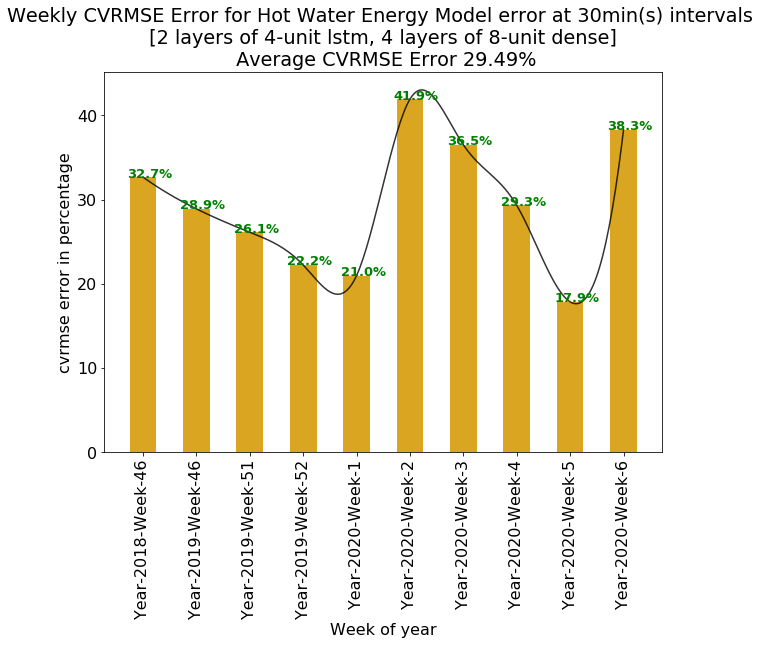

In [56]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Code cemetery

In [ ]:
# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)

In [ ]:
#model.model.summary()

#nn_model.model.layers[-1].input_shape

#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())

#nn_model.model.layers[-1].output_shape